In [1]:
%matplotlib inline
import pandas as pd
from __future__ import division
figsize = (12, 6)

In [2]:
def process_data(df, prefix, names_regexp, names_types):
    import re
    data = df.loc[df.name.str.startswith(prefix)]
    names = data.pop('name')
    input_params = names.str.extract (names_regexp, expand=True)
    param_names = input_params.columns
    for name, name_type in zip(input_params, names_types):
        input_params[name] = input_params[name].astype(name_type)
    data = pd.concat([input_params, data], axis=1)
    return data

In [3]:
csv_data = pd.read_csv('sliderule_2017-01-23-19:24-full.csv', comment='#').dropna(how='all', axis=1)

In [4]:
parallel_data = process_data(csv_data, 'Width',
                             '<(?P<N>\d+)>/(?P<Threads>\d+)/(?P<PartitionSize>[\w.]+)', ['int', 'int', 'int'])
parallel_data.set_index(['Threads', 'N', 'PartitionSize'], inplace=True)

In [5]:
threads_idx_idx = parallel_data.index.names.index('Threads')
threads = parallel_data.index.levels[threads_idx_idx]
num_threads_multi = threads[threads <= 4]

speedups = {}
efficiency = {}
for nt in num_threads_multi[1:]:
    speedups[nt] = parallel_data.loc[1].real_time / parallel_data.loc[nt].real_time
    efficiency[nt] = speedups[nt] / nt

In [6]:
iterative_data = process_data(csv_data, 'Iterative', '<(?P<N>\d+)>', ['int'])
iterative_data.set_index('N', inplace=True)

In [7]:
best_times_single_thread = parallel_data.loc[1].real_time.groupby(level='N').min() # best times for different Ns

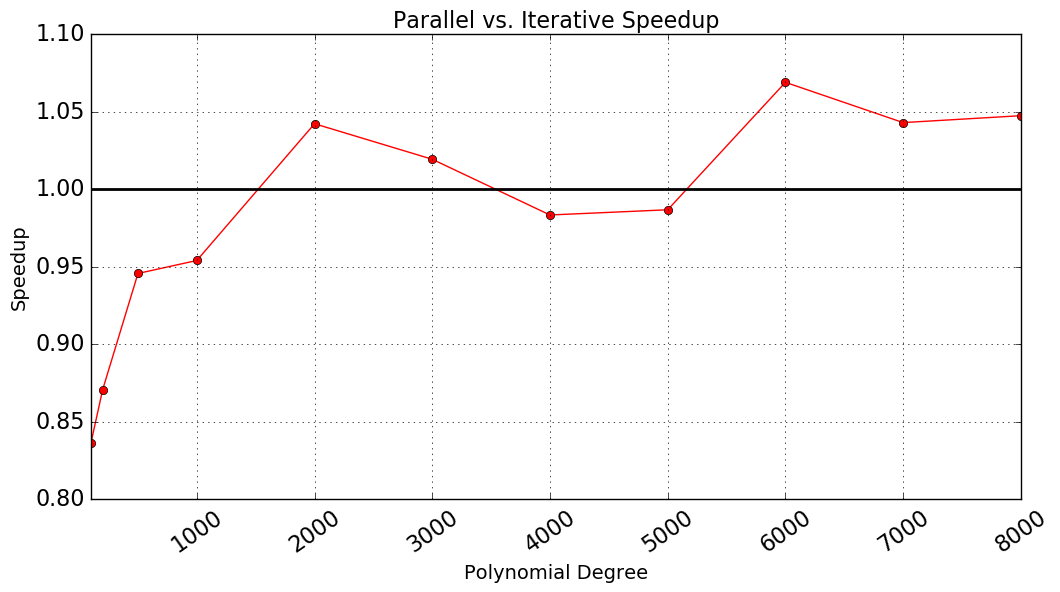

In [8]:
st_speedup = (iterative_data.real_time / best_times_single_thread).dropna()
ax = st_speedup.plot(rot=35, grid=True, style='ro-', figsize=figsize,fontsize=16)

ax.set_xlabel('Polynomial Degree',  {'fontsize': 14})
ax.set_ylabel('Speedup',  {'fontsize': 14})

ax.set_title('Parallel vs. Iterative Speedup', {'fontsize': 16})
ax.axhline(y=1.0, c='k', lw=2)
fig = ax.get_figure()
fig.savefig('/tmp/parallel_vs_iter_speedup.pdf')

# Efficiency
A better metric than the speedup is the efficiency, which simply normalizes the speedup by the number of threads. Therefore, an efficiency of $1$ would correspond to a speedup equal to the number of threads used. Efficiencies $> 1$ can be explained by cache effects, as a result of properly sized subproblems.

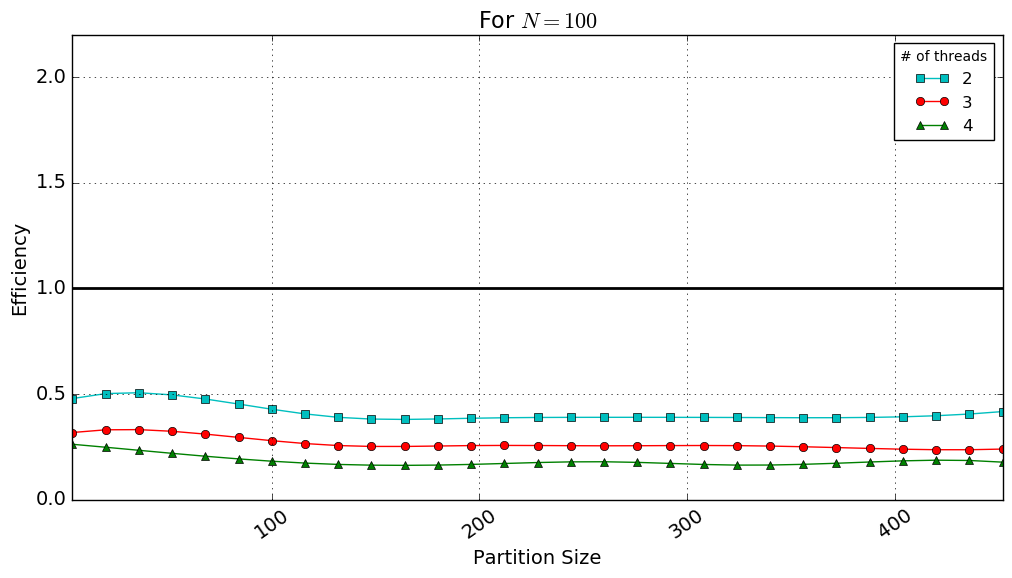

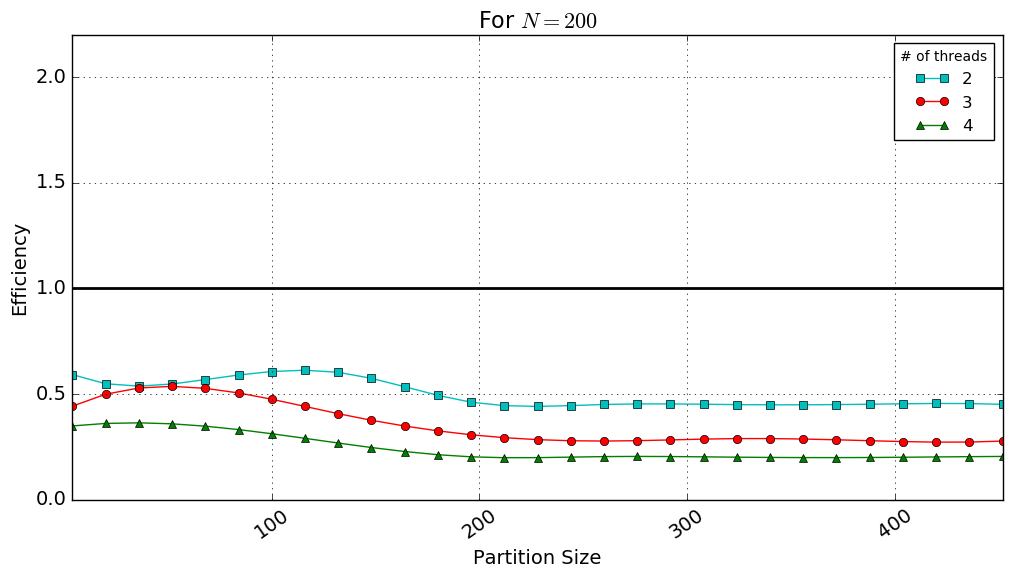

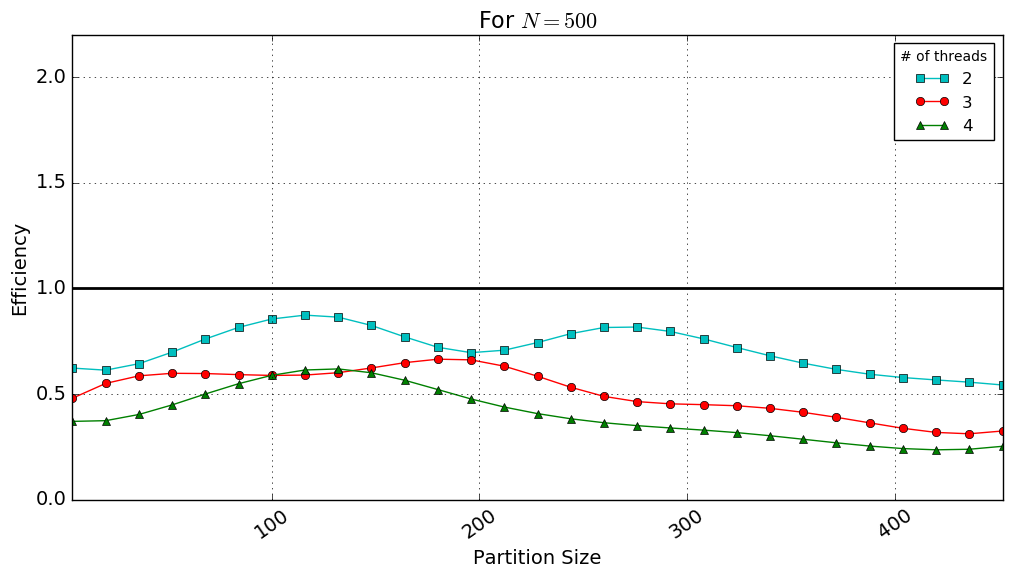

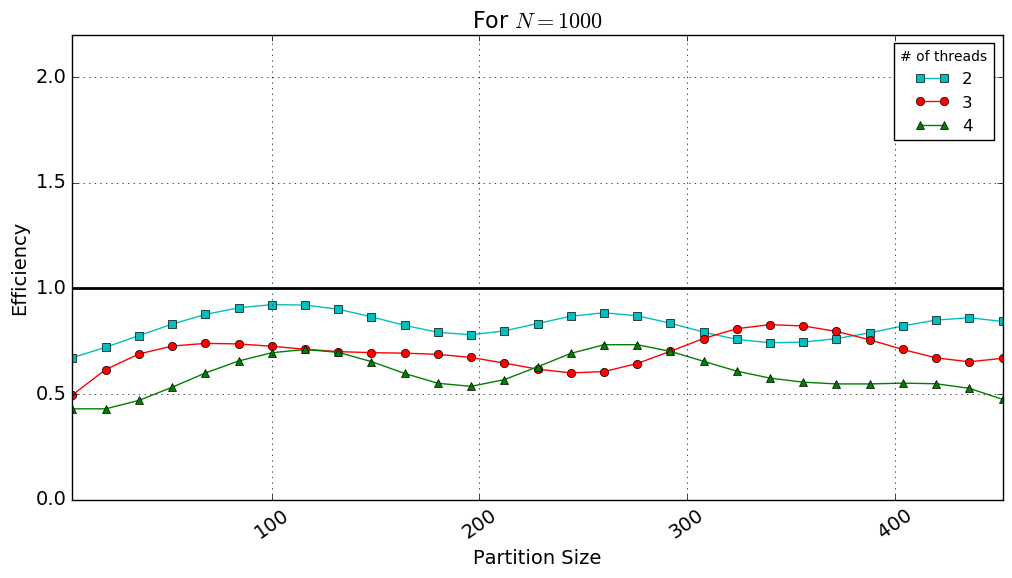

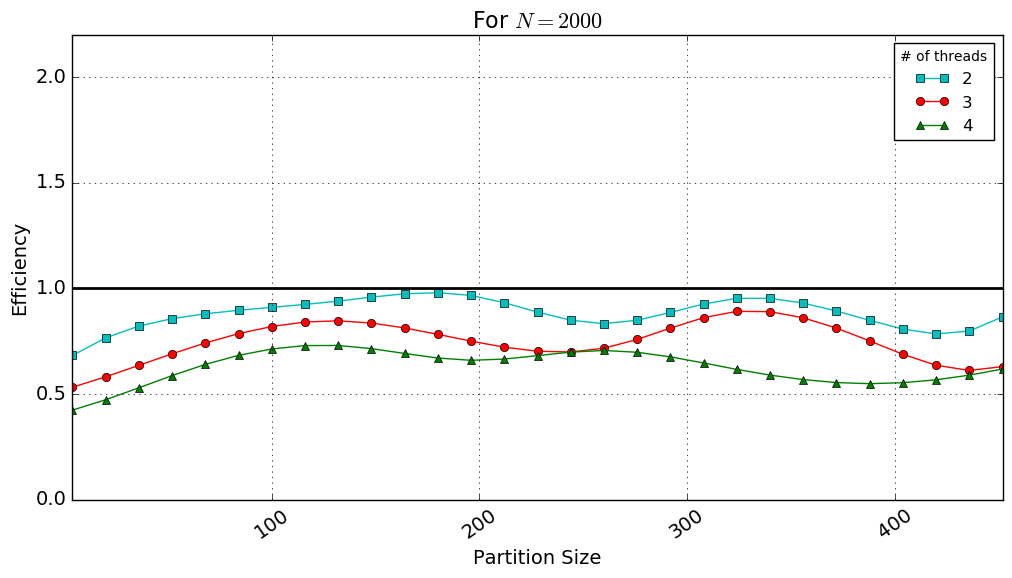

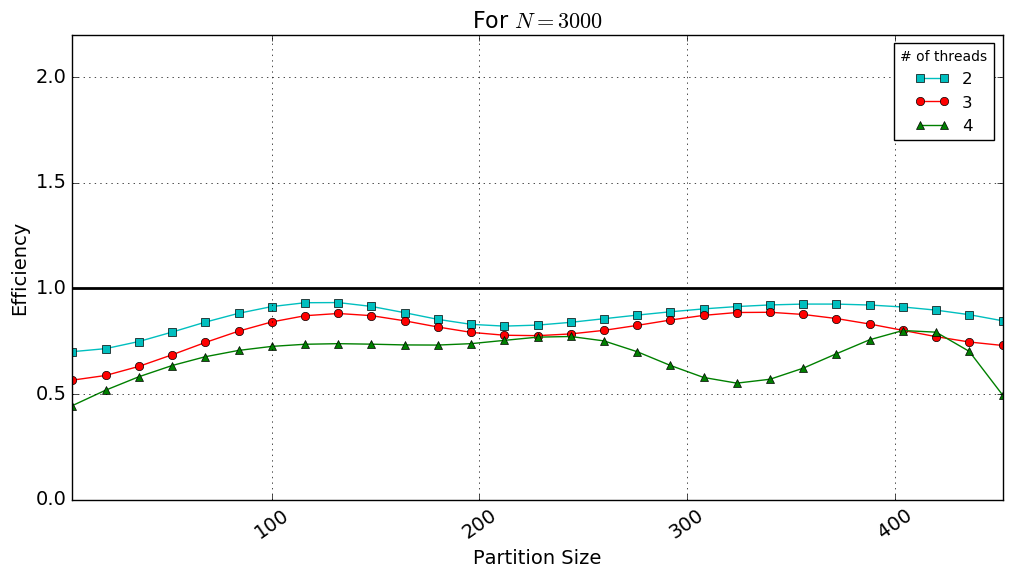

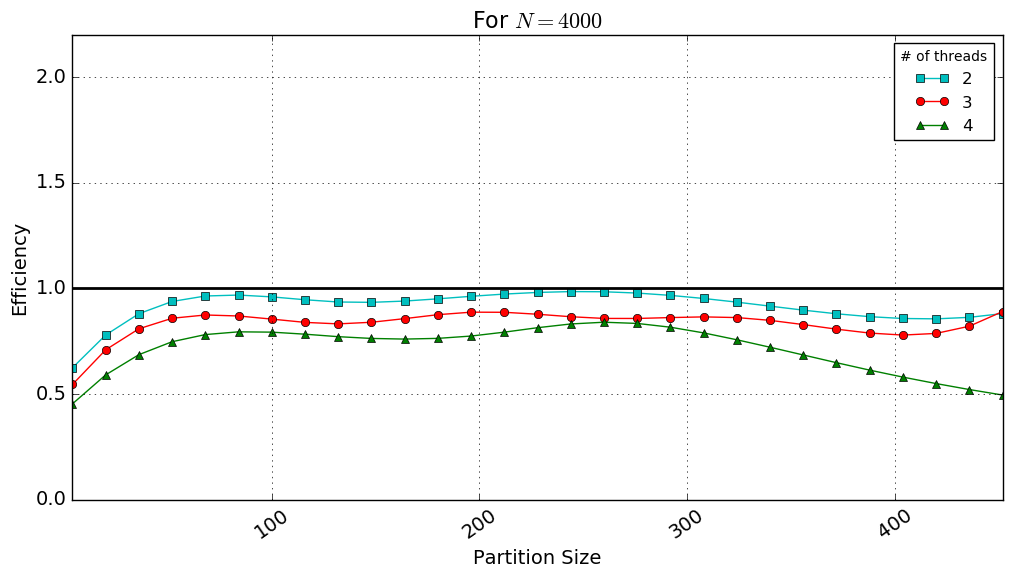

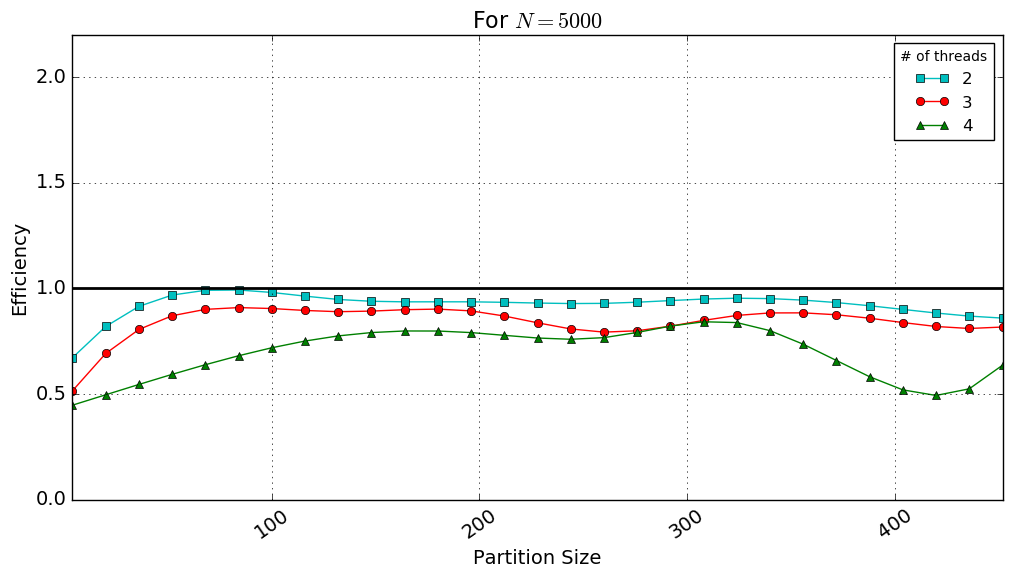

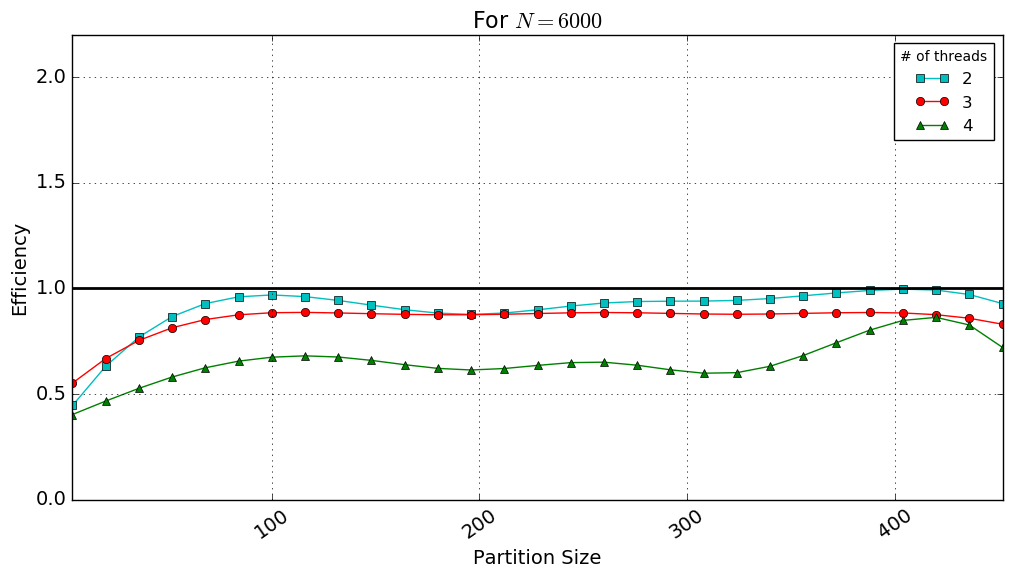

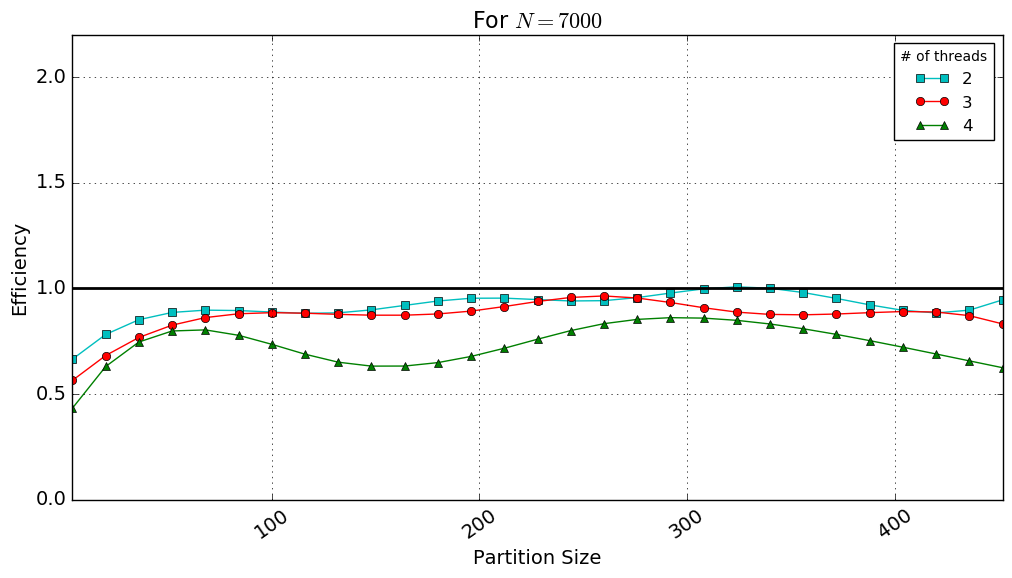

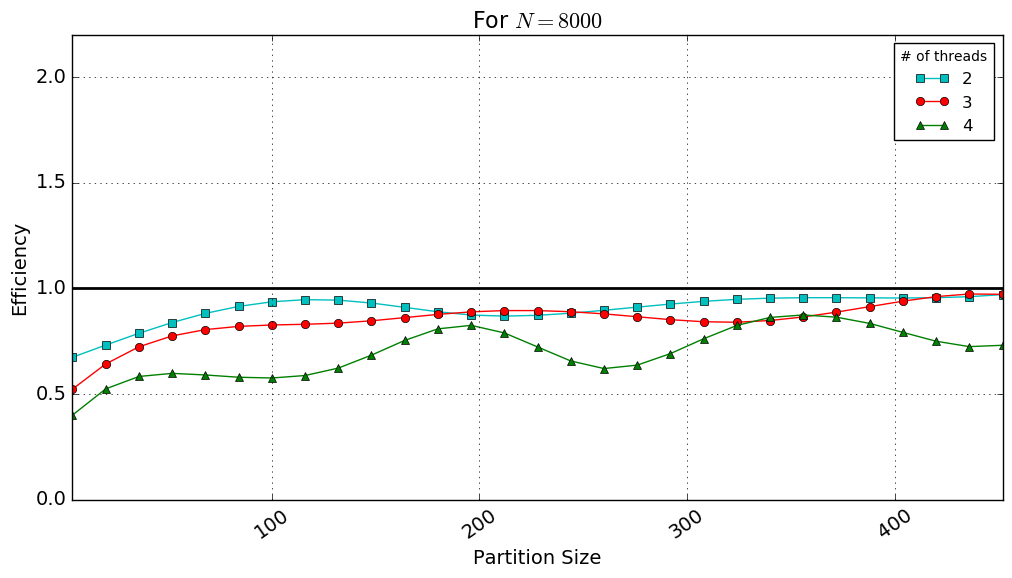

In [9]:
efficiency = pd.DataFrame(efficiency)
efficiency_by_N = efficiency.groupby(level='N') 

for name, group in efficiency_by_N:
    downsampled = group.loc[::16,2:6]
    downsampled.index = downsampled.index.droplevel()
    max_n = int(downsampled.index.max())+1
    interpolated = downsampled.reindex(pd.Index(range(4, max_n, 16))).interpolate(method='cubic')
    ax = interpolated.plot(rot=35, grid=True, style=['cs-', 'ro-', 'g^-', 'kv-', 'bD-'], 
                           figsize=figsize,
                           fontsize=14)
    ax.set_ylim(0, 2.2)
    ax.set_xlabel('Partition Size',  {'fontsize': 14})
    ax.set_ylabel('Efficiency',  {'fontsize': 14})
    ax.set_title('For $N = {}$'.format(int(name)), {'fontsize': 16})
    ax.axhline(y=1.0, c='k', lw=2)
    ax.get_legend().set_title('# of threads')
    fig = ax.get_figure()
    fig.savefig('/tmp/{}.pdf'.format(int(name)))
    

# Maximum efficiencies per degree (N) and number of threads.

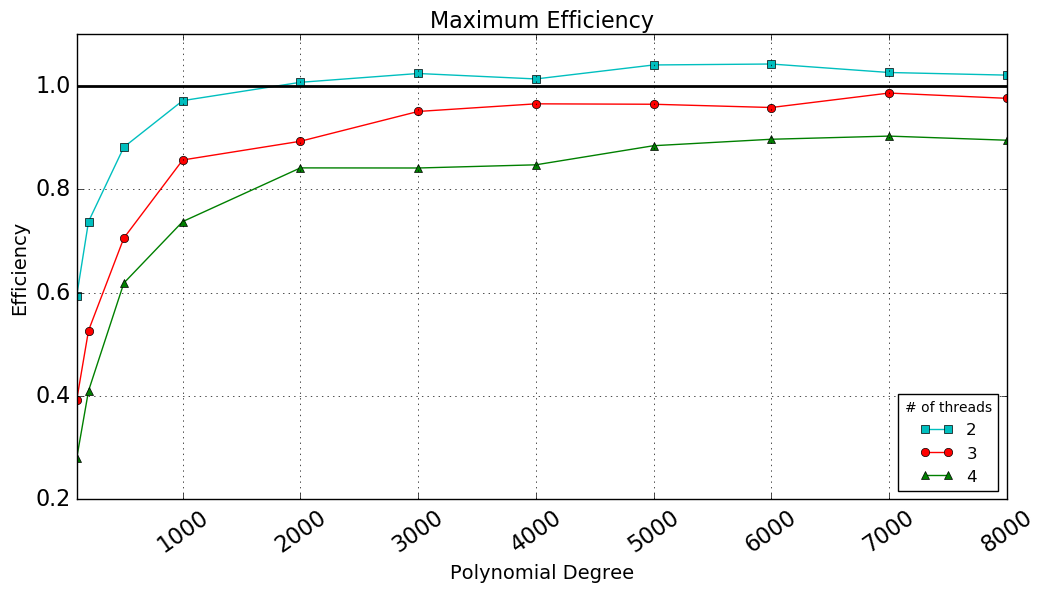

In [10]:
max_eff_by_n = efficiency.groupby(level='N').max()

ax = max_eff_by_n.plot(grid=True, rot=35, figsize=figsize, style=['cs-', 'ro-', 'g^-', 'kv-', 'bD-'], fontsize=16)
ax.set_xlabel('Polynomial Degree',  {'fontsize': 14})
ax.set_ylabel('Efficiency',  {'fontsize': 14})
ax.set_title('Maximum Efficiency', {'fontsize': 16})
ax.axhline(y=1.0, c='k', lw=2)
ax.get_legend().set_title('# of threads')
fig = ax.get_figure()
fig.savefig('/tmp/max_eff_by_n.pdf')

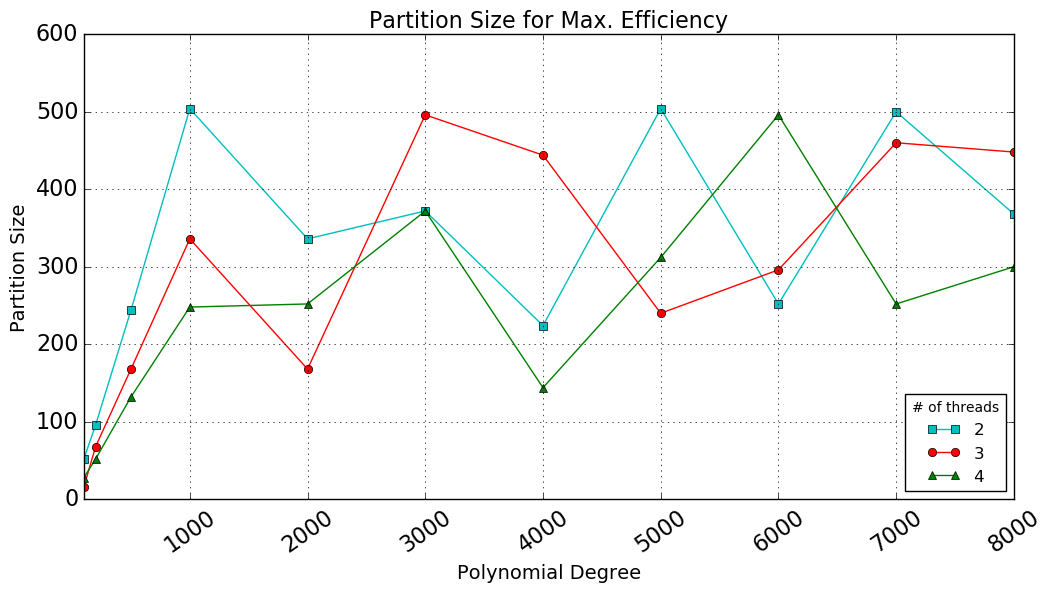

In [11]:
idx_max_eff = efficiency.groupby(level='N').idxmax().apply(lambda row: row.apply(lambda elem: elem[1]), axis='rows')

ax = idx_max_eff.plot(grid=True, rot=35, figsize=figsize, style=['cs-', 'ro-', 'g^-', 'kv-', 'bD-'], fontsize=16)
ax.set_xlabel('Polynomial Degree',  {'fontsize': 14})
ax.set_ylabel('Partition Size',  {'fontsize': 14})
ax.set_title('Partition Size for Max. Efficiency', {'fontsize': 16})
ax.get_legend().set_title('# of threads')
fig = ax.get_figure()
fig.savefig('/tmp/max_eff_idx.pdf')